https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
WWW.KAGGLE.COM

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import SGD, Adam
import matplotlib .pyplot as plt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import zipfile
import shutil
import os
import glob

from tensorflow.keras.applications import Xception, ResNet50
from tensorflow.keras.applications import InceptionV3, MobileNet

# Project-1

###  경로설정

In [2]:
### colab
root_dir = "/content"
data_root_dir = os.path.join(root_dir, "COVID-19_Radiography")
train_data_root_dir = os.path.join(data_root_dir, "train")
test_data_root_dir = os.path.join(data_root_dir, "test")

In [3]:
### pc
root_dir = "content"
data_root_dir = os.path.join(root_dir, "COVID-19_Radiography")
train_data_root_dir = os.path.join(data_root_dir, "train")
test_data_root_dir = os.path.join(data_root_dir, "test")

### 데이터셋 가져오기

In [ ]:
### Colab 실행 경우
from google.colab import drive

drive.mount("/content/")

shutil.copy(os.path.join("/content/drive/My Drive/Colab Notebooks/", "archive.zip"))

if os.path.exists(data_root_dir):
    shutil.rmtree(data_root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "archive.zip")) as target_file:
    target_file.extractall(data_root_dir)

In [3]:
### 내 PC 실행의 경우

if os.path.exists(data_root_dir):
    shutil.rmtree(data_root_dir)

with zipfile.ZipFile(os.path.join(root_dir, "COVID-19_Radiography.zip")) as target_file:
    target_file.extractall(data_root_dir)

### 필요한 폴더 및 파일들만 copy

In [15]:
### 전체 목록 확인
total_file_list = glob.glob(os.path.join(data_root_dir, "COVID-19_Radiography_Dataset/*"))
# print(total_file_list)

### 정답 리스트 추출
label_name_list = [filename.split("\\")[-1].strip() 
                     for filename in total_file_list 
                     if os.path.isdir(filename) == True] # isdir : 폴더면 True 분류
print(label_name_list)


### 각 폴더의 Images 디렉토리를 train/정답이름으로 복사
for label_name in label_name_list:
    src_dir_path = os.path.join(data_root_dir, 
                               "COVID-19_Radiography_Dataset"+"/"+label_name+"/images")
    dst_dir_path = os.path.join(data_root_dir, "train"+"/"+label_name)
    
    try:
        shutil.copytree(src_dir_path, dst_dir_path)
        print(label_name + " copytree is done!")
        
    except Exception as err :
        print(str(err))

['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
COVID copytree is done!
Lung_Opacity copytree is done!
Normal copytree is done!
Viral Pneumonia copytree is done!


### 정답 및 전체 데이터 갯수 확인

In [16]:
### 훈련데이터 갯수 
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))

train label : COVID  => 3616
train label : Lung_Opacity  => 6012
train label : Normal  => 10192
train label : Viral Pneumonia  => 1345


### test 디렉토리 및 하위 디렉토리 생성

In [20]:
### test 디렉토리 생성
if not os.path.exists(test_data_root_dir):
    os.mkdir(test_data_root_dir)
    print(test_data_root_dir + " is created!")
else : 
    print(test_data_root_dir + " already exists")

### test 하위 디렉토리 생성(정답별)
for label_name in label_name_list:
    if not os.path.exists(os.path.join(test_data_root_dir, label_name)):
        os.mkdir(os.path.join(test_data_root_dir, label_name))
        print(os.path.join(test_data_root_dir, label_name) + " is created!")
    else : 
        print(os.paht.join(test_data_root_dir, label_name) + " already exists")

content\COVID-19_Radiography\test already exists
content\COVID-19_Radiography\test\COVID is created!
content\COVID-19_Radiography\test\Lung_Opacity is created!
content\COVID-19_Radiography\test\Normal is created!
content\COVID-19_Radiography\test\Viral Pneumonia is created!


### 각각 정답별로 원하는 비율만큼 train -> test로 move

In [21]:
move_ratio = 0.2

for label_name in label_name_list:
    src = os.path.join(train_data_root_dir, label_name)
    dst = os.path.join(test_data_root_dir, label_name)
    
    train_data_file_list = os.listdir(src)
    
    split_num = int(move_ratio*len(train_data_file_list))
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num += 1

### train과 test 갯수 확인

In [24]:
### 훈련데이터 갯수 
train_label_name_list = os.listdir(train_data_root_dir)

for label_name in train_label_name_list:
    print("train label :", label_name, ' =>',
          len(os.listdir(os.path.join(train_data_root_dir, label_name))))
    
print("==================================================================")
### 테스트 데이터 갯수
test_label_name_list = os.listdir(test_data_root_dir)

for label_name in train_label_name_list:
    print("test label :", label_name, ' =>',
          len(os.listdir(os.path.join(test_data_root_dir, label_name))))

train label : COVID  => 2893
train label : Lung_Opacity  => 4810
train label : Normal  => 8154
train label : Viral Pneumonia  => 1076
test label : COVID  => 723
test label : Lung_Opacity  => 1202
test label : Normal  => 2038
test label : Viral Pneumonia  => 269


### Image Shape 설정

In [25]:
img_width = 100 # Colab에서는 224로
img_height = 100

### ImageDataGenerotor를 이용하여 데이터 불러오기

In [26]:
train_data_gen = ImageDataGenerator(rescale = 1./255)
test_data_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_data_gen.flow_from_directory(directory=train_data_root_dir,
                                  batch_size = 32, 
                                  target_size = (img_height, img_width),
                                  class_mode = "sparse",
                                  color_mode = "rgb")

test_generator = test_data_gen.flow_from_directory(directory=test_data_root_dir, 
                                 batch_size = 32, 
                                 target_size = (img_height, img_width),
                                 class_mode = "sparse",
                                 color_mode = "rgb")

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


In [27]:
print(train_generator.class_indices)
print(train_generator.class_mode)

{'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
sparse


###  Image 확인

In [36]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

(16, 100, 100, 3) (16,)
[2. 2. 2. 0. 0. 2. 1. 0. 0. 1. 2. 1. 0. 0. 0. 2.]


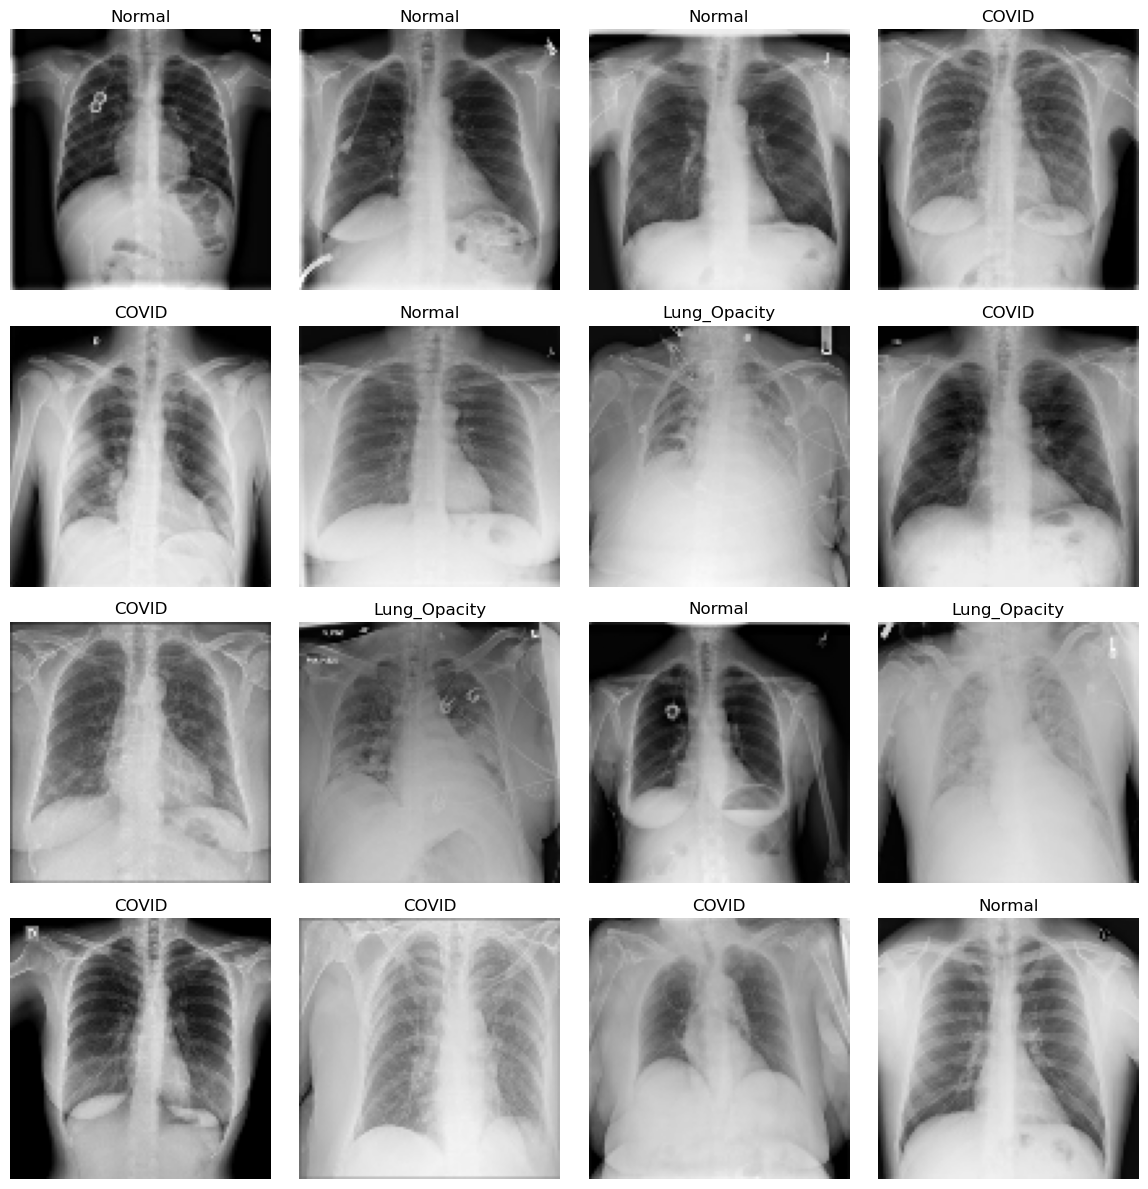

In [38]:
plt.figure(figsize = (12, 12))

class_dict = {0:'COVID', 1:'Lung_Opacity', 2:'Normal', 3:'Viral Pneumonia'}

for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    plt.tight_layout()

### model 구축

In [39]:
pre_trained_model = MobileNet(weights = "imagenet", include_top = False,
                             input_shape=(img_width, img_height, 3)) # 이미지넷에서 학습한 가중치를 사용
pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [40]:
model = Sequential()
model.add(pre_trained_model)
model.add(GlobalAveragePooling2D()) # flatten 대신
model.add(Dense(512, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.5))

model.add(Dense(train_generator.num_classes, activation = "softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [41]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = Adam(1e-5), metrics = ["acc"])

In [43]:
start_time = datetime.now()

result = model.fit(train_generator, epochs = 3, validation_data= test_generator)

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/3
530/530 [==============================] - 403s 759ms/step - loss: 1.6083 - acc: 0.4647 - val_loss: 0.7961 - val_acc: 0.6945
Epoch 2/3
530/530 [==============================] - 291s 549ms/step - loss: 1.0504 - acc: 0.6148 - val_loss: 0.5968 - val_acc: 0.7883
Epoch 3/3
530/530 [==============================] - 327s 616ms/step - loss: 0.8476 - acc: 0.6815 - val_loss: 0.5013 - val_acc: 0.8277
Elapsed Time :  0:17:01.611629
